In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical


/Users/karthickkumarasamy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 📂 Step 2: Load Dataset
df = pd.read_csv("synthetic_5g_qos_dataset_10000.csv")

In [3]:
# Encode categorical features
df['qos_class_enc'] = LabelEncoder().fit_transform(df['qos_class'])

for col in ['source_ip', 'destination_ip', 'protocol']:
    df[col] = LabelEncoder().fit_transform(df[col])

features = ['source_ip', 'destination_ip', 'protocol', 'packet_size', 'inter_arrival_time_ms', 'jitter_ms']
target = 'qos_class_enc'


In [4]:
# Create sequences (sliding window over dataset)
sequence_length = 5
X_seq, y_seq = [], []

df = df.reset_index(drop=True)

for i in range(len(df) - sequence_length):
    seq = df[features].iloc[i:i+sequence_length].values
    label = df[target].iloc[i+sequence_length - 1]
    X_seq.append(seq)
    y_seq.append(label)

X_seq = np.array(X_seq)
y_seq = to_categorical(y_seq)

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Build Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64), input_shape=(sequence_length, len(features))))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/Users/karthickkumarasamy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        36,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,579 (158.51 KB)

 Trainable params: 40,579 (158.51 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4349 - loss: 1.0813 - val_accuracy: 0.6338 - val_loss: 0.7661
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6172 - loss: 0.7914 - val_accuracy: 0.7412 - val_loss: 0.5627
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6722 - loss: 0.6529 - val_accuracy: 0.7188 - val_loss: 0.5431
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6943 - loss: 0.6065 - val_accuracy: 0.7181 - val_loss: 0.5579
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7041 - loss: 0.5855 - val_accuracy: 0.7406 - val_loss: 0.5205
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7128 - loss: 0.5788 - val_accuracy: 0.8150 - val_loss: 0.5021
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7607 - loss: 0.5540 - val_accuracy: 0.8556 - val_loss: 0.3824
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7865 - loss: 0.5051 - val_accuracy: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.99      0.90       695
           1       0.98      0.76      0.86       651
           2       0.99      0.97      0.98       653

    accuracy                           0.91      1999
   macro avg       0.93      0.91      0.91      1999
weighted avg       0.92      0.91      0.91      1999



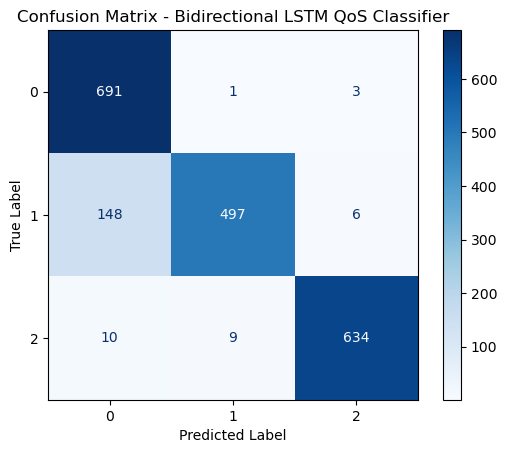

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Bidirectional LSTM QoS Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step

📄 Macro Average AUC: 0.9849
📄 Weighted Average AUC: 0.9849


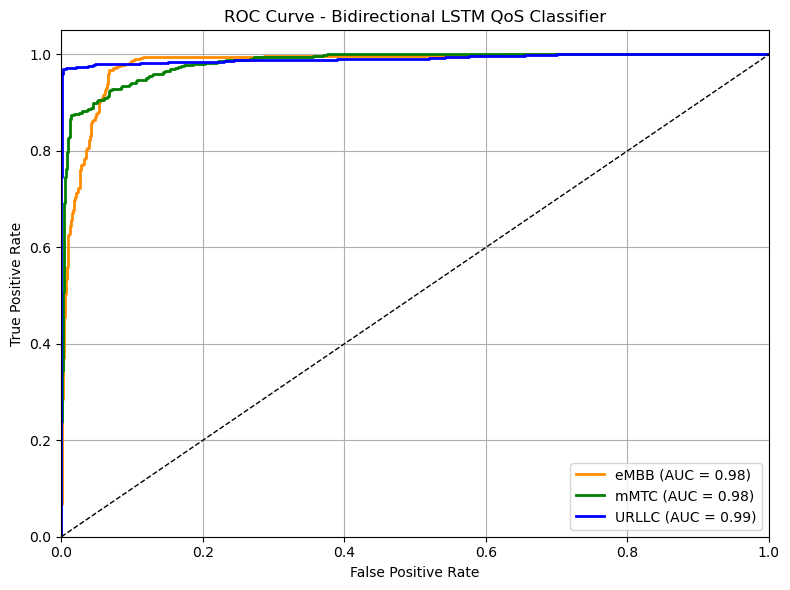

In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# One-hot true labels already available as y_test
n_classes = y_test.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
auc_scores = []

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    auc_scores.append(roc_auc[i])

# Macro and weighted AUC
macro_auc = np.mean(auc_scores)
weighted_auc = roc_auc_score(y_test, y_pred_probs, average='weighted', multi_class='ovr')

print(f"\n📄 Macro Average AUC: {macro_auc:.4f}")
print(f"📄 Weighted Average AUC: {weighted_auc:.4f}")

# Plot ROC curve for each class
class_names = ['eMBB', 'mMTC', 'URLLC']  # Adjust if your class labels differ
colors = cycle(['darkorange', 'green', 'blue'])

plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Bidirectional LSTM QoS Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

